In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from scipy import stats
import numpy as np

from collections import defaultdict
from functools import partial
import os
import re

from tensorflow.python.summary.summary_iterator import summary_iterator
import tensorflow as tf
%matplotlib inline
from matplotlib import rcParams
# Set Helvetica as the default font
rcParams['pdf.use14corefonts'] = True  # Ensures Type 1 fonts (including Helvetica) are used
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Helvetica']
rcParams['figure.figsize'] = [4, 3]
rcParams['axes.unicode_minus'] = False

2025-01-28 10:05:34.034819: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 10:05:34.035022: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 10:05:34.036842: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 10:05:34.060109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-28 10:05:34.507505: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [3]:
DATASET = "cifar100"
log_dir = os.path.join(os.getcwd(), f"../.runs/seq_multiseed/{DATASET}")

In [4]:
experiments = os.listdir(log_dir)
experiments

['sgd_1_of_2',
 'mfvi_1_of_2',
 'mfvi_2_of_2',
 'sgd_2_of_2_from_split1_init',
 'sgd_2_of_2']

## Utils to load experiment results

In [5]:
def parse_sgd_events(eventfile):
    value_by_tag = defaultdict(dict)
    for event in summary_iterator(eventfile):
        for value in event.summary.value:
            value_by_tag[value.tag][event.step] = tf.make_ndarray(value.tensor).squeeze()
    df = pd.DataFrame(value_by_tag).rename_axis("step")
    return df.drop(columns=['command']).astype(float)

In [6]:
def load_sgd_experiment_logs(experiment, experiment_instance=None, events_log=None):
    if experiment_instance is None:
        instances = os.listdir(os.path.join(log_dir, experiment))
        assert len(instances) == 1, f"Manually need to provice experiment instance: {instances}"
        experiment_instance = instances[0]
    if events_log is None:
        events_log = max((os.path.getmtime(os.path.join(log_dir, experiment, experiment_instance, filename)), filename)
                                for filename in filter(
                                    lambda filename: filename.startswith("event"),
                                    os.listdir(os.path.join(log_dir, experiment, experiment_instance))
                                ))[1]
    eventfile = os.path.join(log_dir, experiment, experiment_instance, events_log)
    df = parse_sgd_events(eventfile)
    return df.iloc[list(range(10, len(df), 10)) + [-1]]

In [7]:
def parse_mfvi_events(eventfile):
    value_by_tag = defaultdict(dict)
    for event in summary_iterator(eventfile):
        for value in event.summary.value:
            value_by_tag[value.tag][event.step] = tf.make_ndarray(value.tensor).squeeze()
    df = pd.DataFrame(value_by_tag).rename_axis("step")
    # plt.plot(df['MFVI/param_stds'].iloc[-1][...,0], df['MFVI/param_stds'].iloc[-1][...,2])
    # TODO generate insights from sigma histograms
    return df.drop(columns=['command', 'MFVI/param_stds'], errors='ignore').astype(float, errors='ignore')
    # return df.drop(columns=['command', 'MFVI/param_stds']).astype(float)
def load_mfvi_experiment_logs(experiment, experiment_instance=None, events_log=None):
    if experiment_instance is None:
        instances = os.listdir(os.path.join(log_dir, experiment))
        assert len(instances) == 1, f"Manually need to provice experiment instance: {instances}"
        experiment_instance = instances[0]
    if events_log is None:
        events_log = max((os.path.getmtime(os.path.join(log_dir, experiment, experiment_instance, filename)), filename)
                                for filename in filter(
                                    lambda filename: filename.startswith("event"),
                                    os.listdir(os.path.join(log_dir, experiment, experiment_instance))
                                ))[1]
    eventfile = os.path.join(log_dir, experiment, experiment_instance, events_log)
    df = parse_mfvi_events(eventfile)
    return df.iloc[list(range(10, len(df), 10)) + [-1]]

In [8]:
# Generic and newer implementation
def parse_events(eventfile, drop_seqs=True):
    value_by_tag = defaultdict(dict)
    for event in summary_iterator(eventfile):
        for value in event.summary.value:
            value_by_tag[value.tag][event.step] = tf.make_ndarray(value.tensor).squeeze()
    df = pd.DataFrame(value_by_tag).rename_axis("step")
    return df.drop(columns=['command', 'MFVI/param_stds'], errors='ignore').astype(float, errors='ignore' if drop_seqs else 'raise')
def load_experiment_logs(log_dir, experiment="", experiment_instance=None, events_log=None):
    if experiment_instance is None:
        instances = os.listdir(os.path.join(log_dir, experiment))
        assert len(instances) == 1, f"Manually need to provice experiment instance: {instances}"
        experiment_instance = instances[0]
    if events_log is None:
        events_log = max((os.path.getmtime(os.path.join(log_dir, experiment, experiment_instance, filename)), filename)
                                for filename in filter(
                                    lambda filename: (
                                        filename.startswith("event")
                                        and
                                        # (all("final_eval" not in f for f in os.listdir(os.path.join(log_dir, experiment, experiment_instance))) or "final_eval" in filename)
                                        "final_eval" not in filename
                                        and
                                        float(os.path.getsize(os.path.join(log_dir, experiment, experiment_instance, filename))) > 1e3
                                    ),
                                    os.listdir(os.path.join(log_dir, experiment, experiment_instance))
                                ))[1]
    eventfile = os.path.join(log_dir, experiment, experiment_instance, events_log)
    df = parse_events(eventfile, drop_seqs=True)
    return df.iloc[list(range(10, len(df), 10)) + [-1]].rename_axis('metric', axis=1)

In [9]:
def find_experiment_instance(dir, seed):
    fulldir = os.path.join(os.getcwd(), dir)

    runs = os.listdir(fulldir)
    seed_runs = list(filter(lambda run: re.match(fr".*pretr_[a-z0-9]+_batchsize_80_temp_1.0__seed_{seed}$", run), runs))

    if len(seed_runs) == 0:
        raise KeyError(f"Seed file not found {seed}")
    elif len(seed_runs) == 1:
        return seed_runs[0]
    else:
        raise KeyError(f"Duplicate seed dir found {seed}")

## Utils to clean up data

In [10]:
def winsorize(xs: pd.Series, q_low=0., q_high=1.):
    return xs.clip(*xs.quantile([q_low, q_high]))

def rolling_median(xs, window=35, centred=False, min_periods=1):
    return xs.rolling(window, min_periods=min_periods).median()

## Plotting utils

In [11]:
def plot_agg(df, ax, label, **kwargs):
    line = ax.plot(df.index, df['mean'], label=label, **kwargs)
    ax.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], alpha=0.3, **kwargs)
    return line

## Repro SGD & VI baseline

## Sequential VI

In [120]:
SEEDS = list(range(1, 6+1))
vanilla_experiment_dfs = dict()
for DATASET in ['cifar10', 'imdb']:
    SGD_WEIGHT_DECAY = "3" if DATASET == "imdb" else "10"
    dfs = {}
    for metric_display, (sgd_metric, vi_metric, scale) in {
        'Accuracy': ('test/accuracy', 'test/ens_accuracy', 1),
        'Log-likelihood': ('test/nll', 'test/ens_nll', -1),
        'ECE': ('test/ece', 'test/ens_ece', 1),
    }.items():
        df_sgd_nonseq = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../multiseed/{DATASET}/sgd" if DATASET == "imdb" else f"../../multiseed/sgd/{DATASET}",
                experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_{SGD_WEIGHT_DECAY}.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS
        }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
        df_mfvi_nonseq = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../multiseed/{DATASET}/mfvi" if DATASET == "imdb" else f"../../multiseed/vi/{DATASET}",
                experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS
        }, names=["seed", "step"])[vi_metric].unstack('seed').apply(rolling_median, window=1).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
        df_mfvi_split1 = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../seq_multiseed/{DATASET}/mfvi_1_of_2",
                experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS
        }, names=["seed", "step"])[vi_metric].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)

        df_mfvi_split2 = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../seq_multiseed/{DATASET}/mfvi_2_of_2",
                experiment_instance=find_experiment_instance(f"../.runs/seq_multiseed/{DATASET}/mfvi_2_of_2", seed)
            )
            for seed in SEEDS
        }, names=["seed", "step"])[vi_metric].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)

        df_sgd_split1 = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../seq_multiseed/{DATASET}/sgd_1_of_2",
                experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_{SGD_WEIGHT_DECAY}.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS
        }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
        df_sgd_split2_from_split1_init = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../seq_multiseed/{DATASET}/sgd_2_of_2_from_split1_init",
                experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_{SGD_WEIGHT_DECAY}.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS if not (DATASET == "cifar10" and seed in {8})
        }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median, min_periods=2).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
        dfs[metric_display] = (df_sgd_nonseq, df_mfvi_nonseq, df_mfvi_split1, df_mfvi_split2,
                               df_sgd_split1, df_sgd_split2_from_split1_init)
    vanilla_experiment_dfs[DATASET] = dfs

In [43]:
def plot_sequential_vi_experiment_inner(dfs_by_metric, fig, axs, label=True, DATASET=DATASET):
    COLOR_VI = "#920000"
    COLOR_SEQ_VI = "#c99636"
    COLOR_SGD = "#252525"
    COLOR_SEQ_SGD = "#db6d00"
    gridprops=dict(alpha=0.4)
    dividerprops=dict(ymin=0, ymax=1, dashes=(2,3), linewidth=1.2, color='grey', alpha=0.8)

    for (ax_vi, ax_sgd), (metric, (df_sgd_nonseq, df_mfvi_nonseq, df_mfvi_split1, df_mfvi_split2,
                        df_sgd_split1, df_sgd_split2_from_split1_init)) in zip(axs, dfs_by_metric.items()):

        handle_sgd = plot_agg(df_sgd_nonseq, ax=ax_sgd, label="SGD", color=COLOR_SGD)
        handle_vi = plot_agg(df_mfvi_nonseq, ax=ax_vi, label="MFVI", color=COLOR_VI)
        seq_plot_df = pd.concat([
            df_mfvi_split1,
            df_mfvi_split2.reset_index().assign(step=lambda df: df.step+df_mfvi_split1.index.max()).set_index("step"),
        ])
        # Halve the epochs as each epoch is only using half the dataset
        seq_plot_df.index /= 2.0
        handle_seq_vi = plot_agg(seq_plot_df, ax=ax_vi, label="Sequential MFVI", color=COLOR_SEQ_VI)
        ax_vi.axvline(x=seq_plot_df.index.max()/2.0, **dividerprops)
        ADD_SGD_BASELINE = True
        if ADD_SGD_BASELINE:
            # Add SGD baseline
            seq_plot_df = pd.concat([
                df_sgd_split1,
                df_sgd_split2_from_split1_init.reset_index().assign(step=lambda df: df.step+df_sgd_split1.index.max()).set_index("step"),
            ])
            seq_plot_df.index /= 2.0
            handle_seq_sgd = plot_agg(seq_plot_df, ax=ax_sgd, label='"Sequential" SGD', color=COLOR_SEQ_SGD)
            ax_sgd.axvline(x=seq_plot_df.index.max()/2.0, **dividerprops)
        if label:
            ax_vi.set_ylabel(metric)
        if metric == "ECE":
            ax_vi.set_xlabel("Epoch")
            ax_sgd.set_xlabel("Epoch")
        ax_vi.grid(True, **gridprops), ax_sgd.grid(True, **gridprops)
        # ax.set_title("Sequentially training ResNet-20 FRN Swish on CIFAR10")
        # ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))  # xmax=1 assumes y values are between 0 and 1
        if metric == "Accuracy":
            ax_vi.set_title(f'{dict(imdb="IMDB", cifar10="CIFAR-10", cifar100="CIFAR-100")[DATASET]} VI')
            ax_sgd.set_title(f'{dict(imdb="IMDB", cifar10="CIFAR-10", cifar100="CIFAR-100")[DATASET]} SGD')
            if DATASET == "cifar10":
                ax_vi.set_ylim(0.6, None)
            ax_vi.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
            ax_sgd.set_xticklabels([])
            ax_vi.set_xticklabels([])
        elif metric == "Log-likelihood":
            if DATASET == "cifar10":
                ax_vi.set_ylim(-1.5, None)
                ax_sgd.set_ylim(-1.7, None)
            ax_sgd.set_xticklabels([])
            ax_vi.set_xticklabels([])
        elif metric == "ECE":
            if DATASET == "cifar10":
                ax_sgd.set_ylim(0, 0.3)
            ax_vi.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
            ax_sgd.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    lgd = fig.legend(handles=[handle_vi[0], handle_seq_vi[0], handle_sgd[0], handle_seq_sgd[0]],
        bbox_to_anchor=(0.05, 0.00, 0.9, 0), ncols=4, mode="expand", borderaxespad=0.)

    if label:
        fig.tight_layout()
    return fig, lgd

def plot_sequential_vi_experiment(dfs_by_metric):
    fig = plt.Figure(figsize=(6, 4.5))
    axs = []
    # Accuracy
    tmpax = fig.add_subplot(3, 2, 1)
    axs.append((
        tmpax,
        fig.add_subplot(3, 2, 2, sharey=tmpax)
    ))
    # Log-likelihood
    tmpax = fig.add_subplot(3, 2, 3, sharex=axs[0][0])
    axargs = dict(sharey=tmpax) if DATASET != "imdb" else dict()
    axs.append((
        tmpax,
        fig.add_subplot(3, 2, 4, sharex=axs[0][1], **axargs)
    ))
    # ECE
    axs.append((
        fig.add_subplot(3, 2, 5),
        fig.add_subplot(3, 2, 6)
    ))
    # fig, axs = plt.subplots(ncols=2, nrows=3, sharex='col', figsize=(6, 4.25))
    return plot_sequential_vi_experiment_inner(dfs_by_metric, fig, axs)

## Plot CIFAR-10 and IMDB together

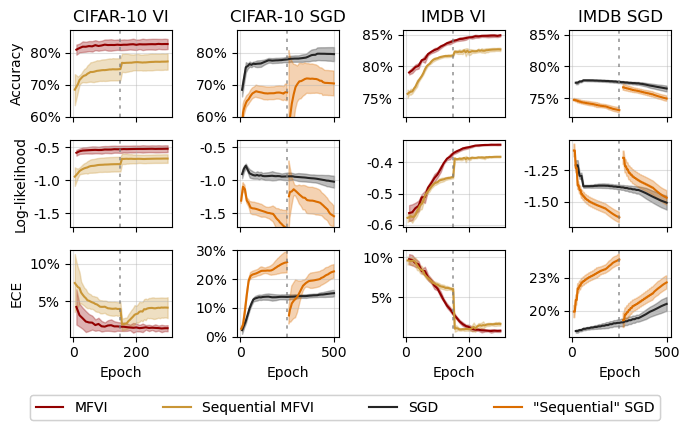

In [162]:
fig = plt.Figure(figsize=(7, 4))
axs = []
# Accuracy
tmpax = fig.add_subplot(3, 4, 1)
tmpax2 = fig.add_subplot(3, 4, 3)
axs.append((
    tmpax,
    fig.add_subplot(3, 4, 2, sharey=tmpax),
    tmpax2,
    fig.add_subplot(3, 4, 4, sharey=tmpax2)
))
# Log-likelihood
tmpax = fig.add_subplot(3, 4, 5, sharex=axs[0][0])
axargs = dict(sharey=tmpax)
axs.append((
    tmpax,
    fig.add_subplot(3, 4, 6, sharex=axs[0][1], **axargs),
    fig.add_subplot(3, 4, 7, sharex=axs[0][2]),
    fig.add_subplot(3, 4, 8, sharex=axs[0][3])
))
# ECE
axs.append((
    fig.add_subplot(3, 4, 9),
    fig.add_subplot(3, 4, 10),
    fig.add_subplot(3, 4, 11),
    fig.add_subplot(3, 4, 12)
))
plot_sequential_vi_experiment_inner(vanilla_experiment_dfs['cifar10'], fig, np.array(axs)[:,:2], DATASET="cifar10")
_, lgd = plot_sequential_vi_experiment_inner(vanilla_experiment_dfs['imdb'], fig, np.array(axs)[:,2:], label=False, DATASET="imdb")
fig.tight_layout()
# fig.savefig(f"plots/seq_vi_cifar10_imdb_with_sgd_baseline_seed1-6.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig

## CIFAR-100

In [44]:
SEEDS = list(range(1, 3+1))
vanilla_experiment_dfs = dict()
for DATASET in ['cifar100']:
    SGD_WEIGHT_DECAY = "3" if DATASET == "imdb" else "10"
    dfs = {}
    for metric_display, (sgd_metric, vi_metric, scale) in {
        'Accuracy': ('test/accuracy', 'test/ens_accuracy', 1),
        'Log-likelihood': ('test/nll', 'test/ens_nll', -1),
        'ECE': ('test/ece', 'test/ens_ece', 1),
    }.items():
        df_sgd_nonseq = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../multiseed/{DATASET}/sgd" if DATASET != "cifar10" else f"../../multiseed/sgd/{DATASET}",
                experiment_instance=f"sgd_mom_0.9__lr_sch_i_1e-06___epochs_500_wd_{SGD_WEIGHT_DECAY}.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS
        }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
        df_mfvi_nonseq = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../multiseed/{DATASET}/mfvi" if DATASET != "cifar10" else f"../../multiseed/vi/{DATASET}",
                experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS
        }, names=["seed", "step"])[vi_metric].unstack('seed').apply(rolling_median, window=1).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
        df_mfvi_split1 = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../seq_multiseed/{DATASET}/mfvi_1_of_2",
                experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS
        }, names=["seed", "step"])[vi_metric].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)

        df_mfvi_split2 = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../seq_multiseed/{DATASET}/mfvi_2_of_2",
                experiment_instance=find_experiment_instance(f"../.runs/seq_multiseed/{DATASET}/mfvi_2_of_2", seed)
            )
            for seed in SEEDS
        }, names=["seed", "step"])[vi_metric].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)

        df_sgd_split1 = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../seq_multiseed/{DATASET}/sgd_1_of_2",
                experiment_instance=f"sgd_mom_0.9__lr_sch_i_1e-06___epochs_500_wd_{SGD_WEIGHT_DECAY}.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS
        }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
        df_sgd_split2 = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../seq_multiseed/{DATASET}/sgd_2_of_2",
                experiment_instance=find_experiment_instance(f"../.runs/seq_multiseed/{DATASET}/sgd_2_of_2", seed)
            )
            for seed in SEEDS if not (DATASET == "cifar10" and seed in {8})
        }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median, min_periods=2).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
        df_sgd_split2_from_split1_init = pd.concat({
            seed: load_experiment_logs(log_dir,
                f"../../seq_multiseed/{DATASET}/sgd_2_of_2_from_split1_init",
                experiment_instance=f"sgd_mom_0.9__lr_sch_i_1e-06___epochs_500_wd_{SGD_WEIGHT_DECAY}.0_batchsize_80_temp_1.0__seed_{seed}"
            )
            for seed in SEEDS if not (DATASET == "cifar10" and seed in {8})
        }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median, min_periods=2).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
        dfs[metric_display] = (df_sgd_nonseq, df_mfvi_nonseq, df_mfvi_split1, df_mfvi_split2,
                            #    df_sgd_split1, df_sgd_split2)# df_sgd_split2_from_split1_init)
                               df_sgd_split1, df_sgd_split2_from_split1_init)
    vanilla_experiment_dfs[DATASET] = dfs

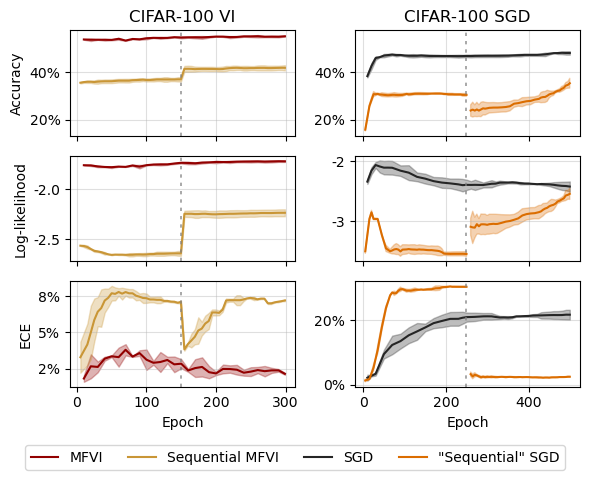

In [32]:
fig, lgd = plot_sequential_vi_experiment(vanilla_experiment_dfs['cifar100'])
fig

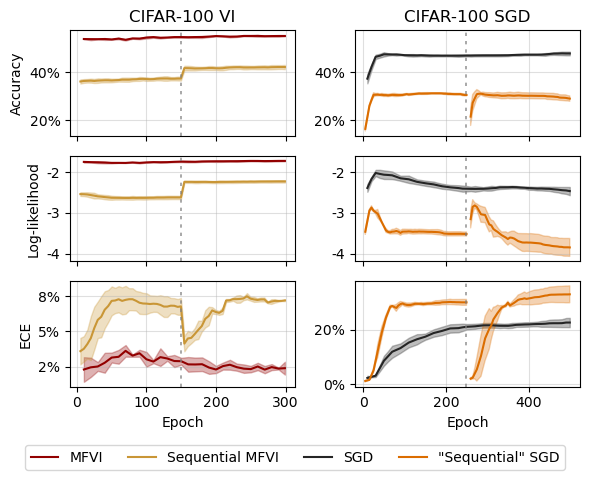

In [47]:
fig, lgd = plot_sequential_vi_experiment(vanilla_experiment_dfs['cifar100'])
# fig.savefig(f"plots/seq_vi_cifar100_with_sgd_baseline_seed1-3.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig

## PCA

In [41]:
REVERSE_SUFFIX="_reverse"
SEEDS = range(1, 6+1)
pca_experiment_dfs = {}
for metric_display, (sgd_metric, vi_metric, scale) in {
    'Accuracy': ('test/accuracy', 'test/ens_accuracy', 1),
    'Log-likelihood': ('test/nll', 'test/ens_nll', -1),
    'ECE': ('test/ece', 'test/ens_ece', 1),
}.items():
    df_sgd_nonseq = pd.concat({
        seed: load_sgd_experiment_logs(
            f"../../multiseed/sgd/{DATASET}",
            experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
        )
        for seed in SEEDS
    }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
    SEEDS = range(1, 6+1)
    df_mfvi_nonseq = pd.concat({
        seed: load_mfvi_experiment_logs(
            f"../../multiseed/vi/{DATASET}",
            experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
        )
        for seed in SEEDS
    }, names=["seed", "step"])[vi_metric].unstack('seed').apply(rolling_median, window=1).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
    df_mfvi_split1 = pd.concat({
        seed: load_mfvi_experiment_logs(
            f"../../seq_multiseed{REVERSE_SUFFIX}/{DATASET}/mfvi_1_of_2_pca",
            experiment_instance=f"mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.0001___epochs_300_wd_5.0_batchsize_80_temp_1.0__seed_{seed}"
        )
        for seed in SEEDS
    }, names=["seed", "step"])[vi_metric].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)

    df_mfvi_split2 = pd.concat({
        seed: load_mfvi_experiment_logs(
            f"../../seq_multiseed{REVERSE_SUFFIX}/{DATASET}/mfvi_2_of_2_pca",
            experiment_instance=find_experiment_instance(f"../.runs/seq_multiseed{REVERSE_SUFFIX}/{DATASET}/mfvi_2_of_2_pca", seed)
        )
        for seed in SEEDS
    }, names=["seed", "step"])[vi_metric].unstack('seed').apply(rolling_median, window=3).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)

    df_sgd_split1 = pd.concat({
        seed: load_sgd_experiment_logs(
            f"../../seq_multiseed{REVERSE_SUFFIX}/{DATASET}/sgd_1_of_2_pca",
            experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
        )
        for seed in SEEDS
    }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
    df_sgd_split2_from_split1_init = pd.concat({
        seed: load_sgd_experiment_logs(
            f"../../seq_multiseed{REVERSE_SUFFIX}/{DATASET}/sgd_2_of_2_pca_from_split1_init",
            experiment_instance=f"sgd_mom_0.9__lr_sch_i_3e-07___epochs_500_wd_10.0_batchsize_80_temp_1.0__seed_{seed}"
        )
        for seed in SEEDS if not (DATASET == "cifar10" and seed in {8})
    }, names=["seed", "step"])[sgd_metric].unstack('seed').apply(rolling_median, min_periods=2).agg([partial(pd.Series.mean, skipna=False), partial(pd.Series.std, skipna=False)], axis=1).mul(scale)
    pca_experiment_dfs[metric_display] = (df_sgd_nonseq, df_mfvi_nonseq, df_mfvi_split1, df_mfvi_split2,
                          df_sgd_split1, df_sgd_split2_from_split1_init)

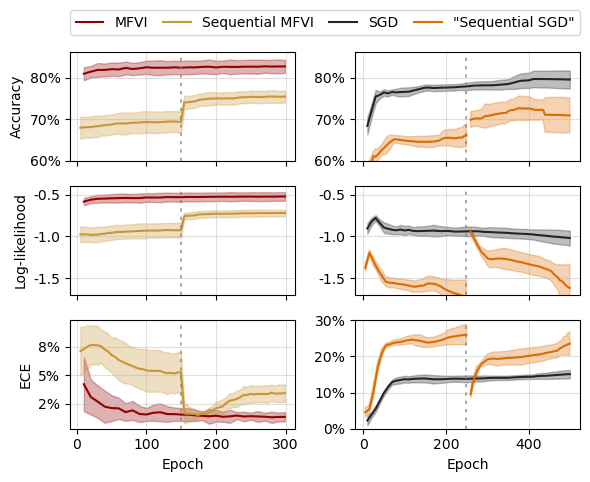

In [42]:
fig, lgd = plot_sequential_vi_experiment(pca_experiment_dfs)
# fig.savefig(f"plots/seq_vi_{DATASET}_pca_with_sgd_baseline_seed1-6.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig